In [30]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
import torch.nn.functional as F
#Image
from PIL import Image
from skimage import io, transform
from IPython.display import display
import matplotlib.pyplot as plt
from torchvision import transforms
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pyplot as plt
import string
# Allows us to use arrays to manipulate and store data
import numpy as np
import random
import seaborn
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
#padding
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [7]:
resnext101=models.resnet.resnext101_32x8d(pretrained=True)

C:\Users\Chanakya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chanakya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


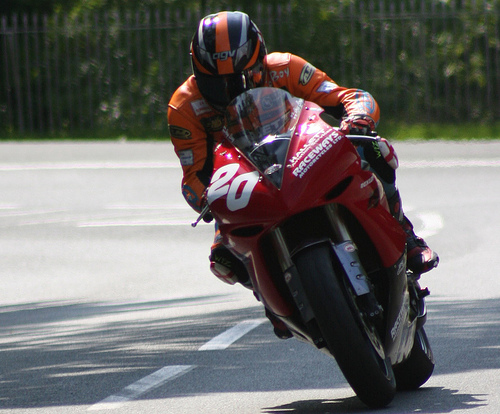

In [8]:
#Sample Image from the Flickr8k Dataset
img=Image.open('Flickr8k/Images/166321294_4a5e68535f.jpg')
img

In [39]:
#Defining transform to get our image to its requirements provided by the ResNext101 Model
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

In [11]:
img_t=transform(img)
img_t.shape

torch.Size([3, 224, 224])

In [13]:
#Checking out ResNext101 for the image
batch_t=torch.unsqueeze(img_t,0)

resnext101.eval()

out = resnext101(batch_t)

#Classes.txt not used in the model, just used to check out ResNext101 predictions
with open('imagenet-classes.txt') as f:
    classes=[line.strip() for line in f.readlines()]

#Percentage Classification for the 1000 classes of image net
_,indices = torch.sort(out, descending=True)
percentage= torch.nn.functional.softmax(out,dim=1)[0]*100
[(classes[idx],percentage[idx].item()) for idx in indices[0][:10]]

[('crash helmet', 86.33792114257812),
 ('moped', 8.645784378051758),
 ('motor scooter, scooter', 4.135242462158203),
 ('backpack, back pack, knapsack, packsack, rucksack, haversack',
  0.35519689321517944),
 ('disk brake, disc brake', 0.3526058793067932),
 ('knee pad', 0.023360732942819595),
 ('mountain bike, all-terrain bike, off-roader', 0.01304687187075615),
 ('mask', 0.010668694041669369),
 ('neck brace', 0.009629393927752972),
 ('mailbag, postbag', 0.007179671432822943)]

In [14]:
#Converting our txt captions file to a csv file
data = pd.read_csv('Flickr8k/captions.txt')
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [17]:
def preprocess_caption(caption):
    punct_table = str.maketrans("", "", string.punctuation)
    # Extract separate tokens
    caption = caption.split()
    # Make tokens lowercase
    caption = [word.lower() for word in caption]
    # Remove punctuation
    caption = [word.translate(punct_table) for word in caption]
    # Remove single letters
    caption = [word for word in caption if len(word) > 1]
    # Remove numbers
    caption = [word for word in caption if word.isalpha()]
    return " ".join(caption)


In [19]:
# Perfromed the preprocessing on the entire dataset
minl=1000
maxl=-1
for i,caption in enumerate(data['caption']):
    caption=preprocess_caption(caption)
    minl=min(minl,len(caption.split()))
    maxl=max(maxl,len(caption.split()))
    data['caption'][i]=caption
data

,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
...,...,...
40450,997722733_0cb5439472.jpg,man in pink shirt climbs rock face
40451,997722733_0cb5439472.jpg,man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,person in red shirt climbing up rock face cove...
40453,997722733_0cb5439472.jpg,rock climber in red shirt


In [20]:
#defining a dictionary containing all the captions for the key(image)
image_captions=dict()
count=0
for image in data['image'].unique():
    key=image.split(".")[0]
    
    image_captions[key]=[]
    for caption in (data.loc[data['image']==image]['caption']):
        
        #we only will append the captions whose length is more than 1, have a one word caption does not make sense
        if(len(caption.split()) >=2):
            
            #tokens for SOS and EOS
            caption='startseq ' + caption + ' endseq'
            
            image_captions[key].append(caption)
    if(len(image_captions[key]) !=5):
        count=count+1
    

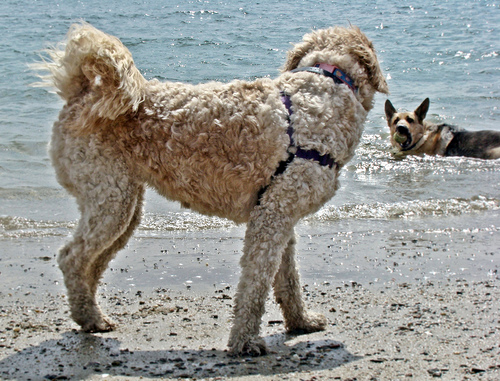

startseq beige dog with collar looks on as brown dog swims in the water endseq
startseq curly coated dog looking at another dog in the water endseq
startseq curly haired dog is standing on beach while staring at dog in deep water endseq
startseq white curly haired dog is wearing harness and watching another black and brown dog in the water endseq
startseq wooly dog on beach looks toward another dog in the water endseq


In [31]:
random_key = random.choice(list(image_captions.keys()))
imgrandom = Image.open(f'Flickr8k/Images/{random_key}.jpg')
display(imgrandom)
for caption in image_captions[random_key]:
    print(caption)

In [48]:
# We build the Encoder CNN with the pretrained ResNext101 model
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderCNN, self).__init__()
        
        # get the pretrained densenet model
        self.resnext101 = resnext101
        
        #Freeze the parameters
        for param in self.resnext101.parameters():
            param.requires_grad = False
       
        # fully connected layer
        self.resnext101.fc = nn.Linear(in_features=2048, out_features=hidden_size)
        
        # dropout layer
#         self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.relu = nn.ReLU()
        
#         self.activation={}
    
    def get_activation(self,name):
        def hook(resnext101, input, output):
             self.activation[name] = output.detach()
        return hook
       
    def forward(self, images):

        # extracting the feature vector from the second last layer( pooling layer )
#         self.resnext101.avgpool.register_forward_hook(self.get_activation('feats'))
        
        features=self.resnext101(images)
        
        #the extracted feature output from the ResNext101
#         feature_output = self.activation['feats']

        #Output of the added FC layer
        encoder_output = (self.relu(features))
        
        return encoder_output

In [32]:
#Vocabulary list of our dataset
def vocab(text):
    vocab_list=set()
    for key in text.keys():
        for line in text[key]:
            words=line.split()
            for word in words:
                vocab_list.add(word)
    return vocab_list

vocab_list=vocab(image_captions)

In [33]:
#tokenize all of the captions
inttoword=dict()
wordtoint=dict()
idx=2
inttoword[0]='startseq'
wordtoint['startseq']=0
inttoword[1]='endseq'
wordtoint['endseq']=1
inttoword[8765]=''
wordtoint['']=8765

for word in vocab_list:
    if word=='startseq' or word=='endseq':
        continue
    inttoword[idx]=word
    wordtoint[word]=idx
    idx+=1

In [34]:
#numericalize all of the captions
maxlength=0
minlength=100
numerical_captions = {}
for image, captions in image_captions.items():
    numerical_captions[image] = []
    for caption in captions:
        # Split the caption into words
        words = caption.split()
        # Numericalize the words using the word_to_int dictionary
        numerical_caption = [wordtoint[word] for word in words]
        maxlength=max(maxlength,len(numerical_caption))
        minlength=min(minlength,len(numerical_caption))
        # Append the numericalized caption to the list
        numerical_captions[image].append(torch.tensor(numerical_caption))

In [37]:
#Splitting of dataset into Training,Validation,Testing (4:1:1)

keys = list(numerical_captions.keys())
values = list(numerical_captions.values())

# Split the keys and values into train, validation, and test sets
train_keys, remaining_keys, train_values, remaining_values = train_test_split(keys, values, test_size=0.2, random_state=42)
val_keys, test_keys, val_values, test_values = train_test_split(remaining_keys, remaining_values, test_size=0.5, random_state=42)

# Create train, validation, and test dictionaries
train_dict = {k: v for k, v in zip(train_keys, train_values)}
val_dict = {k: v for k, v in zip(val_keys, val_values)}
test_dict = {k: v for k, v in zip(test_keys, test_values)}

In [40]:
#Building loaders for training
train_images=[]
train_captions=[]
for image in train_dict.keys():
    img=Image.open(f'Flickr8k/Images/{image}.jpg')
    img_t=transform(img)
    for caption in train_dict[image]:
        train_captions.append(caption)
        train_images.append(img_t)
        
val_images=[]
val_captions=[]
for image in val_dict.keys():
    img=Image.open(f'Flickr8k/Images/{image}.jpg')
    img_t=transform(img)
    for caption in val_dict[image]:
        val_captions.append(caption)
        val_images.append(img_t)

test_images=[]
test_captions=[]
for image in test_dict.keys():
    img=Image.open(f'Flickr8k/Images/{image}.jpg')
    img_t=transform(img)
    for caption in test_dict[image]:
        test_captions.append(caption)
        test_images.append(img_t)
        
class CustomDataset(Dataset):
    def __init__(self, input_list, output_list):
        self.input_list = input_list
        self.output_list = output_list

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, idx):
        input_data = self.input_list[idx]
        output_data = self.output_list[idx]
        return input_data, output_data
    
paddedtrain_captions = pad_sequence(train_captions,batch_first=True, padding_value=8765)
paddedval_captions = pad_sequence(val_captions,batch_first=True, padding_value=8765)
paddedtest_captions = pad_sequence(test_captions,batch_first=True, padding_value=8765)

train_data=CustomDataset(train_images,paddedtrain_captions)
val_data=CustomDataset(val_images,paddedval_captions)
test_data=CustomDataset(test_images,paddedtest_captions)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=0)

In [41]:
#Getting word embeddings from Glove
glove_dir= 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs= np.asarray(values [1:], dtype='float32')
    embeddings_index [word] = torch.tensor(coefs)
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embeddings_index['startseq']= torch.zeros(50)
embeddings_index['endseq']=torch.ones(50)

In [43]:
cnt=0
for word in vocab_list:
    if word not in embeddings_index:
        cnt+=1
print("Misspelled words in vocab_list:",cnt)   

Misspelled words in vocab_list: 1006


In [44]:
#We will initialize the known vocab embeddings from Glove, and randomly initialize for the unknown words
#Will use these pretrained_embeddings to initialize the nn.Embedding layer
pretrained_embeddings = torch.zeros(len(inttoword), 50)
for word, index in wordtoint.items():
            if word in embeddings_index:
        # Use the pretrained embedding for the word
                pretrained_embeddings[index] = torch.Tensor(embeddings_index[word])
            else:
        # Initialize with random values or a default value
                pretrained_embeddings[index] = torch.randn(50)

In [45]:
#The RNN part of the model, which takes in the feature vector as the initial hidden state in the lstm
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        self.embed_size=50
        self.hidden_size = hidden_size
        
        self.vocab_size = vocab_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=self.embed_size, hidden_size=hidden_size)
    
        # embedding layer
        self.embedlayer = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        #initializing embeddings
        self.embedlayer.weight = nn.Parameter(pretrained_embeddings)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
        
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
    #forward would be used only for training
    def forward(self, features, captions):
        
        # batch size
        batch_size = features.size(0)
        
        #padding of captions to make them have the same length
        padded_captions = pad_sequence(captions, batch_first=True, padding_value=8765)
        
        # init the hidden state to the features
        hidden_state = features
 
        #init the cell state to zeroes
        cell_state = torch.zeros((batch_size, self.hidden_size))
    
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, padded_captions.size(1),self.vocab_size))

        # embed the captions
        captions_embed = self.embedlayer(padded_captions)
        
        # pass the caption word by word
        for t in range(padded_captions.size(1)):

            # for the first time step the input is the feature vector
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:,t,:], (hidden_state, cell_state))
                
            # for the 2nd+ time step, using teacher forcer
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            
            # output probabilities of the LSTM mdodel
            out_prob = self.fc_out(hidden_state)
            
            # build the output tensor
            outputs[:, t,:] = out_prob
 
        return outputs

In [49]:
#Some Testing
encoder=EncoderCNN(256)
decoder=DecoderRNN(256,8766)


In [52]:
#Some Testing
output=encoder(batch_t)
caption=decoder(output, [numerical_captions['3549673305_4dfd44e04a'][0]])
caption.size()

torch.Size([1, 10, 8766])

In [53]:
class CNNtoRNN(nn.Module):
    def __init__(self,hidden_size,vocab_size):
        super(CNNtoRNN,self).__init__()
        
        self.hidden_size=hidden_size
        self.vocab_size=vocab_size
        
        self.encoder=EncoderCNN(self.hidden_size)
    
        self.decoder=DecoderRNN(self.hidden_size,self.vocab_size)
        
    def forward(self, images, captions):
        
        features = self.encoder(images)
        
        outputs=self.decoder(features, captions)
        
        return outputs
    
    def caption(self,image):
        result=[]
        with torch.no_grad():
            #feature vector obtained from the encoder (only for one image)
            feature=self.encoder(image)
    
            #initial hidden state is our feature vector
            hidden_state=feature.expand(1,-1)
 
            cell_state = torch.zeros(1,self.hidden_size)
           
            #first input shall be the start token given by the model itself
            max_index=torch.tensor(0)
            
            for i in range(50):
            
                hidden_state,cell_state = self.decoder.lstm_cell(self.decoder.embedlayer(max_index).expand(1,-1),(hidden_state,cell_state))
                
                out_prob=self.decoder.softmax(self.decoder.fc_out(hidden_state))
                
                _,max_index = torch.max(out_prob,dim=1)
                
                if max_index.item()==1:
                    break
                    
                result.append(inttoword[max_index.item()])
                
        return " ".join(result)
            
        
        
        

In [54]:
#Some Testing
image_captioner=CNNtoRNN(256,8766)
image_captioner.caption(batch_t)

'bucket busstop vast tipping moped fill slippery slippery widows lighting picure hits darkly darkly interviewing tipping footballs sailboats barbed holding holding holding animals darkly darkly exposing tipping lighting amused footballs barbed holding holding darkly holding holding animals darkly darkly exposing tipping lighting amused footballs barbed holding holding darkly holding holding'

In [55]:
#Training

image_captioner=CNNtoRNN(256,8766)

def train_model(num_epochs):

    train_loss_history=[]
    val_loss_history=[]
    for name, param in image_captioner.encoder.resnext101.named_parameters():
        if not name.startswith('fc'):  # Exclude the fc layer
            param.requires_grad = False
    
    for epoch in range(num_epochs):
        train_loss_sum=0
        val_loss_sum=0
        
        #Training
        image_captioner.train()
        idx=1
        for images,captions in train_loader:
            print('train',idx)
            idx+=1
            outputs= image_captioner.forward(images,captions)
            loss=criterion(outputs.view(-1, 8766),captions.contiguous().view(-1))
            loss.backward()
            optimizer.step()
            train_loss_sum+=loss
        idx=1    
        #Validation
        image_captioner.eval()
        
        for images,captions in val_loader:
            print('val',idx)
            idx+=1
            outputs= image_captioner.forward(images,captions)
            loss=criterion(outputs.view(-1, 8766),captions.contiguous().view(-1))
            val_loss_sum+=loss
            
        train_loss=train_loss_sum/len(train_loader)
        val_loss=val_loss_sum/len(val_loader)
        
        print(f"Epoch: {epochs + 1}")
        print(f"Training:: Loss : {train_loss_history[epochs]}")
        print(f"Validation:: Loss : {val_loss_history[epochs]}")
        
    return (train_loss_history,val_loss_history)

In [ ]:
criterion=nn.CrossEntropyLoss(ignore_index=8765)
optimizer=optim.Adam(image_captioner.parameters(),lr=0.006)
loss_history,acc_history = train_model(6)

train 1
train 2
train 3
train 4
